<a href="https://colab.research.google.com/github/ejerasga/Horse-and-Human-Image-Classifier-using-Transfer-Learning/blob/main/Transfer_Learning_using_MobileNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the dataset
I use a large set of images of horses and humans from https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=horses_or_humans

In [ ]:
import os
import tensorflow as tf

PATH = '/content/drive/MyDrive/dataset/horse-or-human'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


# Visualize a sample of images from the training dataset

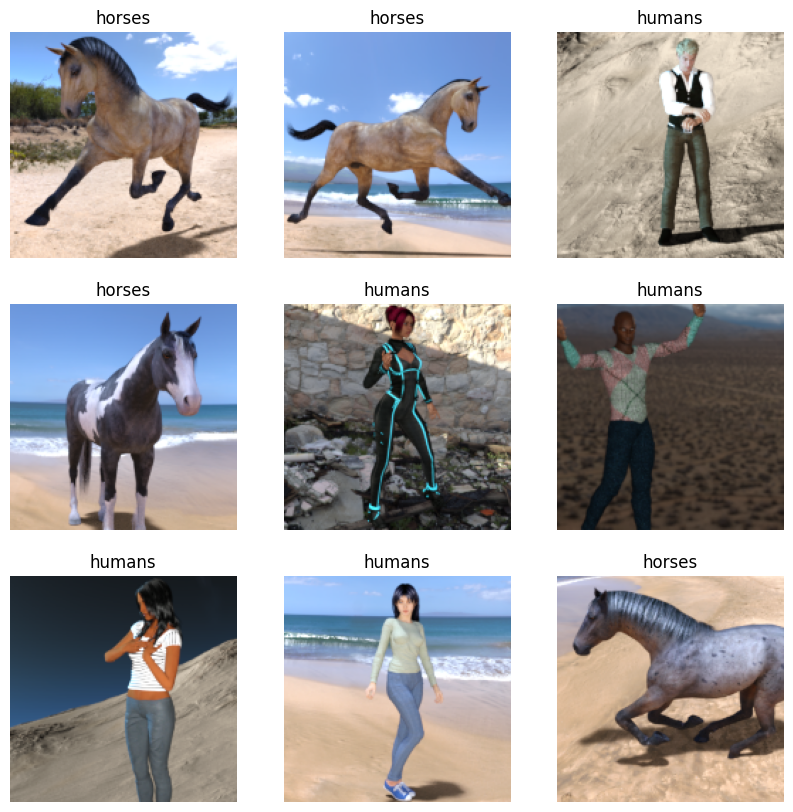

In [ ]:
import matplotlib.pyplot as plt


class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

# the operator '//' is simply a floor division. val_batches is an integer. Whatever the value of val_batches divided by 5, will only return the quotient without the remainder.
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

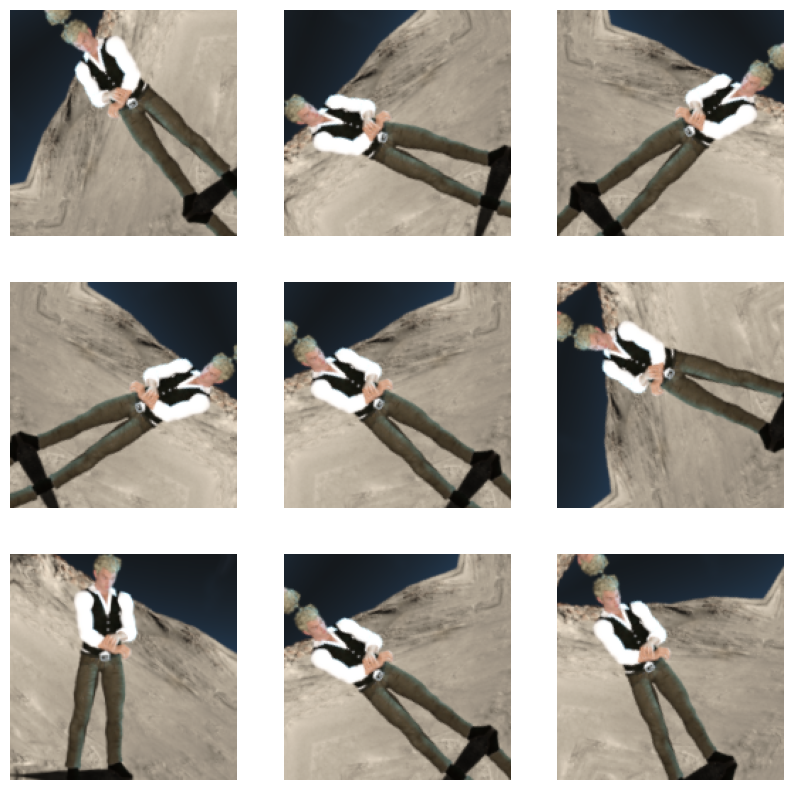

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

7/7 [==============================] - 40s 547ms/step - loss: 0.6815 - accuracy: 0.4866
initial loss: 0.68
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
33/33 [==============================] - 72s 2s/step - loss: 0.8367 - accuracy: 0.4927 - val_loss: 0.5398 - val_accuracy: 0.5938
Epoch 2/10
33/33 [==============================] - 38s 1s/step - loss: 0.6705 - accuracy: 0.6193 - val_loss: 0.4305 - val_accuracy: 0.6964
Epoch 3/10
33/33 [==============================] - 32s 945ms/step - loss: 0.6050 - accuracy: 0.6631 - val_loss: 0.3757 - val_accuracy: 0.7232
Epoch 4/10
33/33 [==============================] - 38s 1s/step - loss: 0.4799 - accuracy: 0.7663 - val_loss: 0.2993 - val_accuracy: 0.8259
Epoch 5/10
33/33 [==============================] - 33s 951ms/step - loss: 0.4199 - accuracy: 0.8082 - val_loss: 0.2699 - val_accuracy: 0.8616
Epoch 6/10
33/33 [==============================] - 33s 931ms/step - loss: 0.3584 - accuracy: 0.8520 - val_loss: 0.2293 - val_accuracy: 0.9286
Epoch 7/10
33/33 [==============================] - 33s 952ms/step - loss: 0.3302 - accuracy: 0.8637 - val_loss: 0.2052 - val_accuracy: 0.9375
Epoch 8/

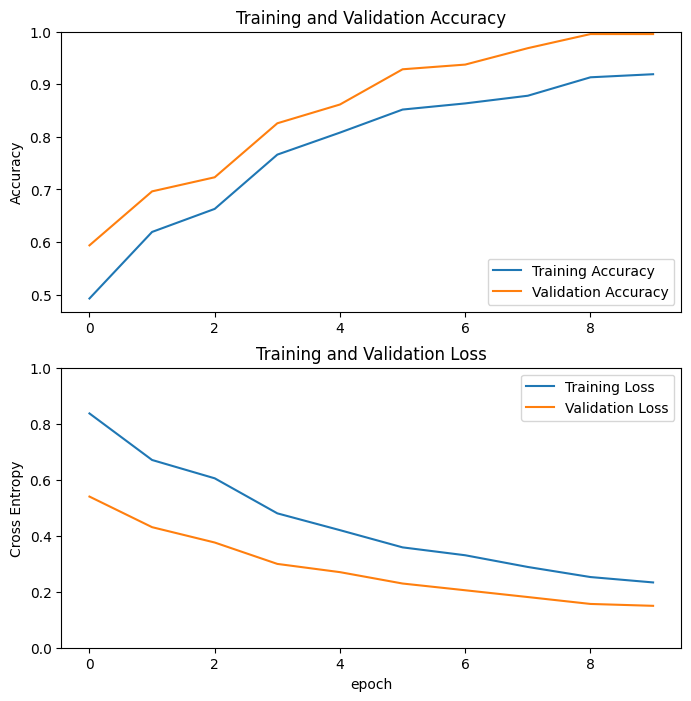

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Epoch 10/20
33/33 [==============================] - 61s 2s/step - loss: 0.1015 - accuracy: 0.9766 - val_loss: 0.0162 - val_accuracy: 1.0000
Epoch 11/20
33/33 [==============================] - 54s 2s/step - loss: 0.0347 - accuracy: 0.9893 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 12/20
33/33 [==============================] - 54s 2s/step - loss: 0.0185 - accuracy: 0.9932 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 13/20
33/33 [==============================] - 50s 1s/step - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 14/20
33/33 [==============================] - 50s 1s/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 15/20
33/33 [==============================] - 50s 1s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9955
Epoch 16/20
33/33 [==============================] - 48s 1s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 8.5532e-04 - val_accuracy: 1.0000
Epoch 17/

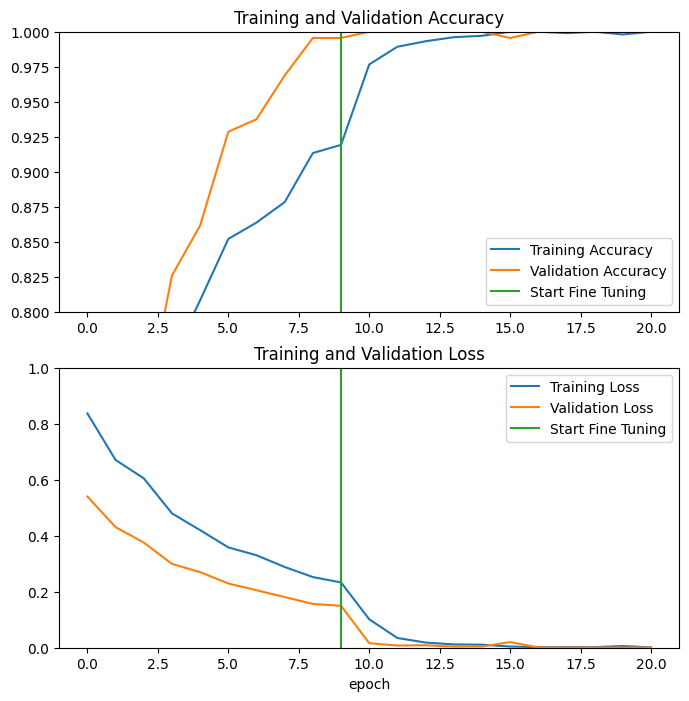

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 3.4103e-04 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1]
Labels:
 [1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1]


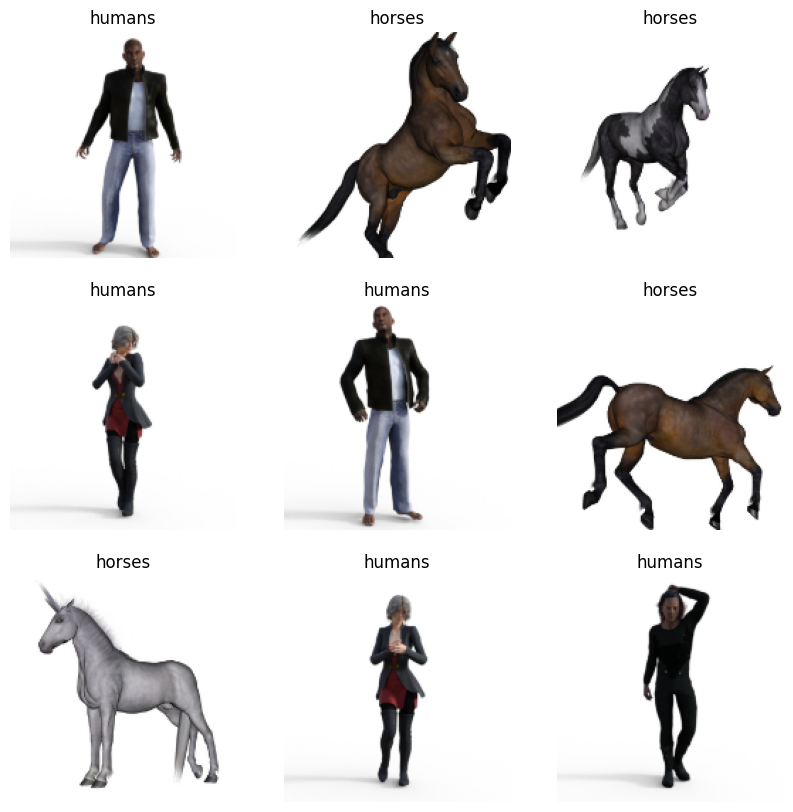

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Upload an image file
uploaded = files.upload()

# Get the file name
file_name = next(iter(uploaded))

# Load and preprocess the uploaded image
image = Image.open(file_name)
image = image.convert("RGB")  # Convert the image to RGB format
image = image.resize((160, 160))  # Resize the image to (160, 160)
image = np.array(image)  # Convert the image to a NumPy array

# Add an extra dimension to match the model's input shape
input_image = np.expand_dims(image, axis=0)

# Make predictions
predictions = model.predict(input_image)

# Post-process the predictions
class_names = ['horse', 'human']  # Assuming binary classification
predicted_class = np.argmax(predictions)
predicted_label = class_names[predicted_class]

# Visualize the image and prediction
plt.imshow(image)
plt.title(predicted_label)
plt.axis('off')
plt.show()

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Upload an image file
uploaded = files.upload()

# Get the file name
file_name = next(iter(uploaded))

# Load and preprocess the uploaded image
image = Image.open(file_name)
image = image.convert("RGB")  # Convert the image to RGB format
image = image.resize((160, 160))  # Resize the image to (160, 160)
image = np.array(image)  # Convert the image to a NumPy array

# Add an extra dimension to match the model's input shape
input_image = np.expand_dims(image, axis=0)

# Make predictions
predictions = model.predict(input_image)

# Post-process the predictions
class_names = ['horse', 'human']  # Assuming binary classification
predicted_class = np.argmax(predictions)
predicted_label = class_names[predicted_class]

# Visualize the image and prediction
plt.imshow(image)
plt.title(predicted_label)
plt.axis('off')
plt.show()

https://www.kaggle.com/datasets/sanikamal/horses-or-humans-dataset